In [40]:
import GPy
from GPy import kern
from GPy.models.bayesian_gplvm_minibatch import BayesianGPLVMMiniBatch
import numpy as np

max_iters=20000
percent_missing=.10
d=13
batchsize=2
D1, D2, D3, N, num_inducing, Q = d, 5, 8, 400, 3, 4
plot_sim=1
Q_signal = 4
np.random.seed(3000)
k = GPy.kern.Matern32(Q_signal, 1., lengthscale=(np.random.uniform(1, 6, Q_signal)), ARD=1)
for i in range(Q_signal):
    k += GPy.kern.PeriodicExponential(1, variance=1., active_dims=[i], period=3., lower=-2, upper=6)
    t = np.c_[[np.linspace(-1, 5, N) for _ in range(Q_signal)]].T
    K = k.K(t)
s2, s1, s3, sS = np.random.multivariate_normal(np.zeros(K.shape[0]), K, size=(4))[:, :, None]
def generate_high_dimensional_output(D1, D2, D3, s1, s2, s3, sS):
    S1 = np.hstack([s1, sS])
    S2 = np.hstack([sS])
    S3 = np.hstack([s1, s3, sS])
    Y1 = S1.dot(np.random.randn(S1.shape[1], D1))
    Y2 = S2.dot(np.random.randn(S2.shape[1], D2))
    Y3 = S3.dot(np.random.randn(S3.shape[1], D3))
    Y1 += .3 * np.random.randn(*Y1.shape)
    Y2 += .2 * np.random.randn(*Y2.shape)
    Y3 += .25 * np.random.randn(*Y3.shape)
    Y1 -= Y1.mean(0)
    Y2 -= Y2.mean(0)
    Y3 -= Y3.mean(0)
    Y1 /= Y1.std(0)
    Y2 /= Y2.std(0)
    Y3 /= Y3.std(0)
    return Y1, Y2, Y3, S1, S2, S3
Y1, Y2, Y3, S1, S2, S3 = generate_high_dimensional_output(D1, D2, D3, s1, s2, s3, sS)
slist = [sS, s1, s2, s3]
slist_names = ["sS", "s1", "s2", "s3"]
Ylist = [Y1, Y2, Y3]
Y = Ylist[0]
k = kern.Linear(Q, ARD=True)  # + kern.white(Q, _np.exp(-2)) # + kern.bias(Q)
inan = np.random.binomial(1, percent_missing, size=Y.shape).astype(bool)  # 80% missing data
Ymissing = Y.copy()
Ymissing[inan] = np.nan


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i       f              |g|        
    00s05  00003   3.878497e+03   8.516932e+03 
    00s15  00011   2.389895e+03   7.361666e+03 
    00s19  00014   2.081993e+03   4.180950e+03 
    00s65  00066   1.028753e+03   4.168951e-02 
Runtime:     00s65
Optimization status: Converged



 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/__init__.py:1855: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


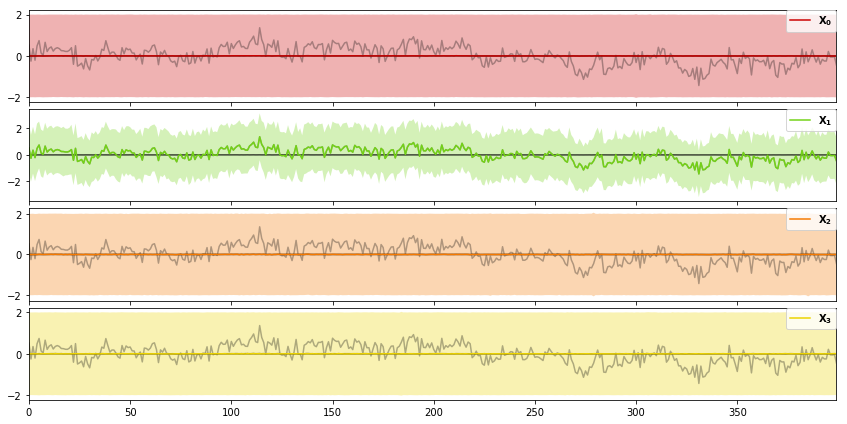

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


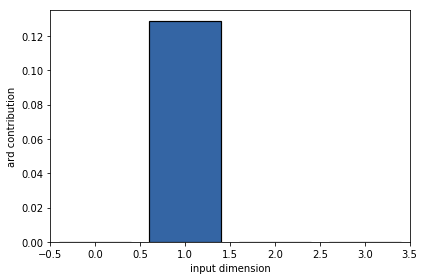

In [41]:
verbose=1
m = BayesianGPLVMMiniBatch(Ymissing, Q, init="random", num_inducing=num_inducing,
    kernel=k, missing_data=True, stochastic=True, batchsize=batchsize)
m.Yreal = Y
m.optimize('bfgs', messages=verbose, max_iters=max_iters,
                   gtol=.05)
m.X.plot("BGPLVM Latent Space 1D")
m.kern.plot_ARD()